# Tabular Kaggle Project

Guideline for steps for the Kaggle Tabular Project. You will "turn in" a GitHub repository, modeled after [Project Template](https://github.com/UTA-DataScience/ProjectTempate) on the day of the final, May 3rd 1:30 pm. During the final period we will have about 5 minutes to go over your project and your results.

You can find a list of possible Tabular datasets here on [Excel File in Teams](https://mavsuta.sharepoint.com/:x:/r/sites/Course_2242_data_3402_001-vUhPXzAGLgTnk/Shared%20Documents/General/TabularDatasets.xlsx?d=w17e157db75904dfcb03a78c84f10e2e6&csf=1&web=1&e=KHi7m9). You are not limited to these datasets. If you find a Kaggle challenge not listed that you would like to attempt, please go check with Dr. Farbin to make sure it is viable.

This notebook outlines the steps you should follow. The file(s) in the GitHub repository should contain these steps. Note that you will be only considering classification projects.

## Define Project

* Provide Project link.
* Short paragraph describing the challenge.
* Briefly describe the data.


##### **Kaggle Dataset**
Dataset: https://www.kaggle.com/competitions/playground-series-s3e22/overview

Column Information: https://www.kaggle.com/datasets/yasserh/horse-survival-dataset

##### **Challenge**
- Given various medical indicators, predict the health outcomes of horses.
  
##### **Data Description**
- train.csv (229.2 kB)
- test.csv (148.32 kB)
- 28 features not including the target variable

## Data Loading and Initial Look

* Load the data.
* Count the number of rows (data points) and features.
* Any missing values?
* Make a table, where each row is a feature or collection of features:
    * Is the feature categorical or numerical
    * What values?
        * e.g. for categorical: "0,1,2"
        * e.g. for numerical specify the range
    * How many missing values
    * Do you see any outliers?
        * Define outlier.
* For classification is there class imbalance?
* What is the target:
    * Classification: how is the target encoded (e.g. 0 and 1)?
    * Regression: what is the range?

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [52]:
# import csv files/load data
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

numerical_columns = train.select_dtypes(include=['int', 'float']).columns
object_columns = train.select_dtypes(include=['object']).columns

In [94]:
# rows and columns
train.shape

(1235, 29)

In [54]:
# categorical vs numerical
dtype={}
for col in train.columns:
    type_=train[col].dtypes
    if type_=="float64" or type_=="int64":
        type_str="numerical"
    else:
        type_str="categorical"
    dtype.update({col:type_str})

features_df=pd.DataFrame([dtype], index=["data_type"]).T

# value
value={}
for col in train.columns:
    dtype = train[col].dtype
    if dtype=="float64" or dtype=="int64":
        min_=train[col].min()
        max_=train[col].max()
        value.update({col:f"{min_} - {max_}"})
    else:
        count=train[col].nunique()
        value.update({col:f"0 - {count-1}"})

# missing values
null={}
for col in train.columns:
    null_count=train[col].isnull().sum()
    null.update({col:null_count})

# percent null values
per_null={}
for col in train.columns:
    null_per=(train[col].isnull().sum()/len(train[col]))*100
    per_null[col] = null_per

# outliers: based on IQR method
def outliers(column):
    import numpy as np
    Q1=np.percentile(column, 25)
    Q3=np.percentile(column, 75)
    IQR=Q3-Q1
    upper_bound=1.5*IQR+Q3
    lower_bound=Q1-1.5*IQR
    no_outliers=(column<upper_bound) & (column>lower_bound)
    num_outliers=(column>upper_bound) & (column<lower_bound)
    return no_outliers, num_outliers

outlier={}
for col in numerical_columns:
    clean,out=outliers(train[col])
    count=out.sum()
    outlier.update({col:count})



features_df["value_range"]=value
features_df["null_count"]=null
features_df["null_%"]=per_null
features_df["outlier_count"]=outlier

features_df

,data_type,value_range,null_count,null_%,outlier_count
id,numerical,0 - 1234,0,0.000000,0.0
surgery,categorical,0 - 1,0,0.000000,NaN
age,categorical,0 - 1,0,0.000000,NaN
hospital_number,numerical,521399 - 5305129,0,0.000000,0.0
rectal_temp,numerical,35.4 - 40.8,0,0.000000,0.0
pulse,numerical,30.0 - 184.0,0,0.000000,0.0
respiratory_rate,numerical,8.0 - 96.0,0,0.000000,0.0
temp_of_extremities,categorical,0 - 3,39,3.157895,NaN
peripheral_pulse,categorical,0 - 3,60,4.858300,NaN
mucous_membrane,categorical,0 - 5,21,1.700405,NaN


In [55]:
# For classification is there class imbalance?
### yes

In [56]:
# target
### column: outcome
### categorical: lived, died, euthanized --> will label encode
train["outcome"].unique()

array(['died', 'euthanized', 'lived'], dtype=object)

## Data Visualization

* For classification: compare histogram every feature between the classes. Lots of examples of this in class.
* For regression:
    * Define 2 or more class based on value of the regression target.
        * For example: if regression target is between 0 and 1:
            * 0.0-0.25: Class 1
            * 0.25-0.5: Class 2
            * 0.5-0.75: Class 3
            * 0.75-1.0: Class 4
    * Compare histograms of the features between the classes.
        
* Note that for categorical features, often times the information in the histogram could be better presented in a table.    
* Make comments on what features look most promising for ML task.

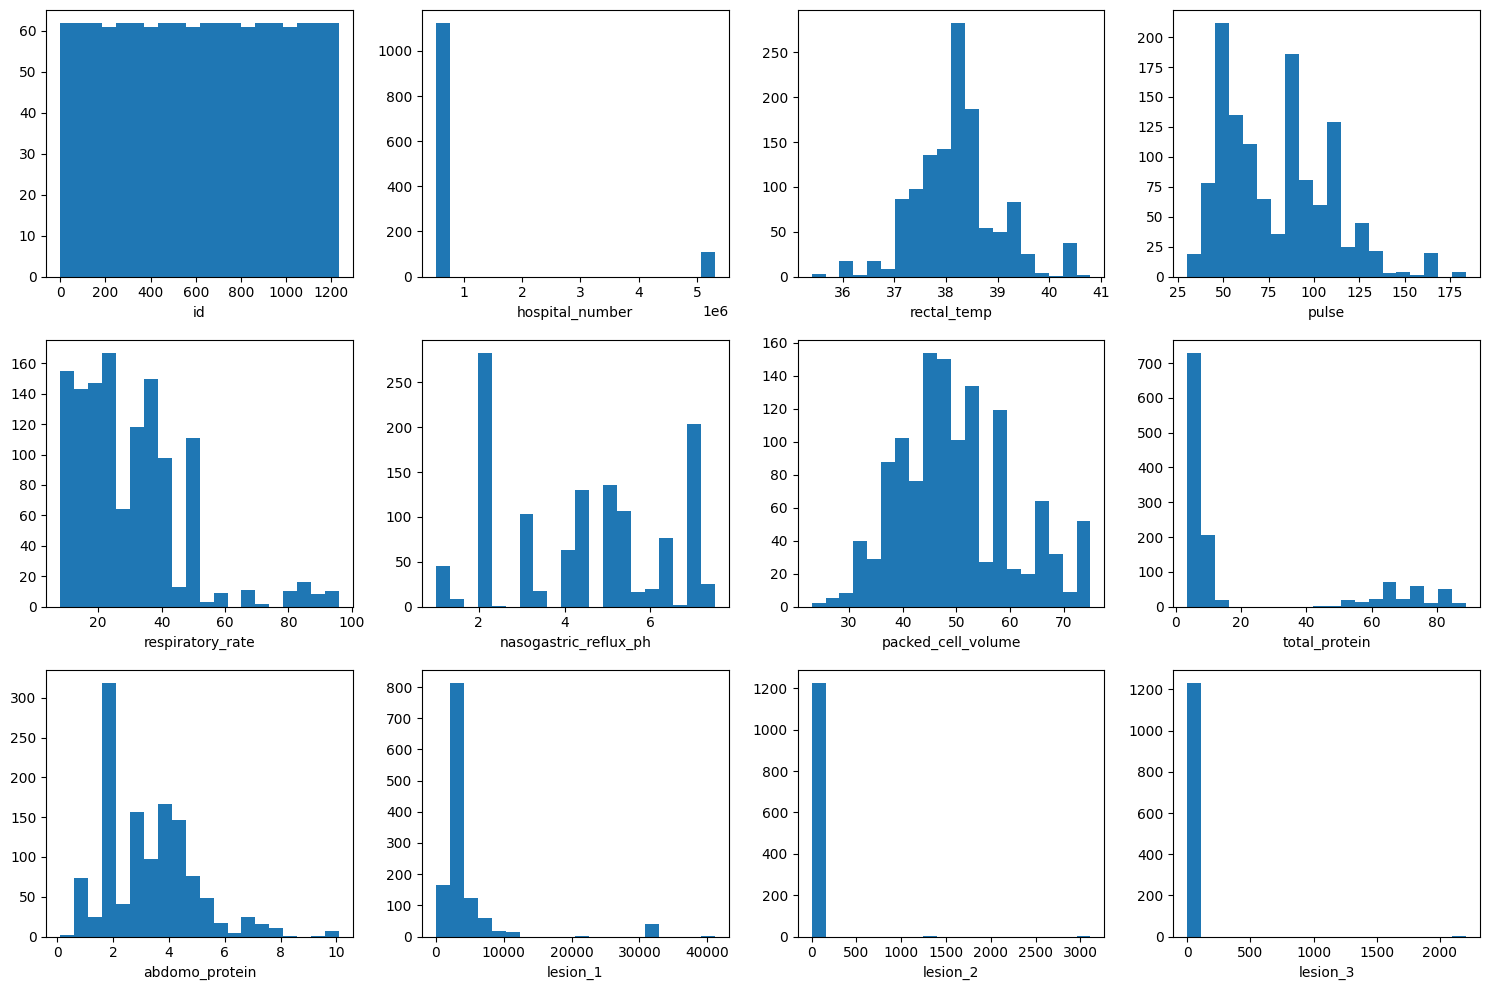

In [57]:
# numerical values --> histogram
plt.figure(figsize=(15,10))
for i,col in enumerate(numerical_columns):
    plt.subplot(3,4,i+1)
    plt.hist(train[col],bins=20)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

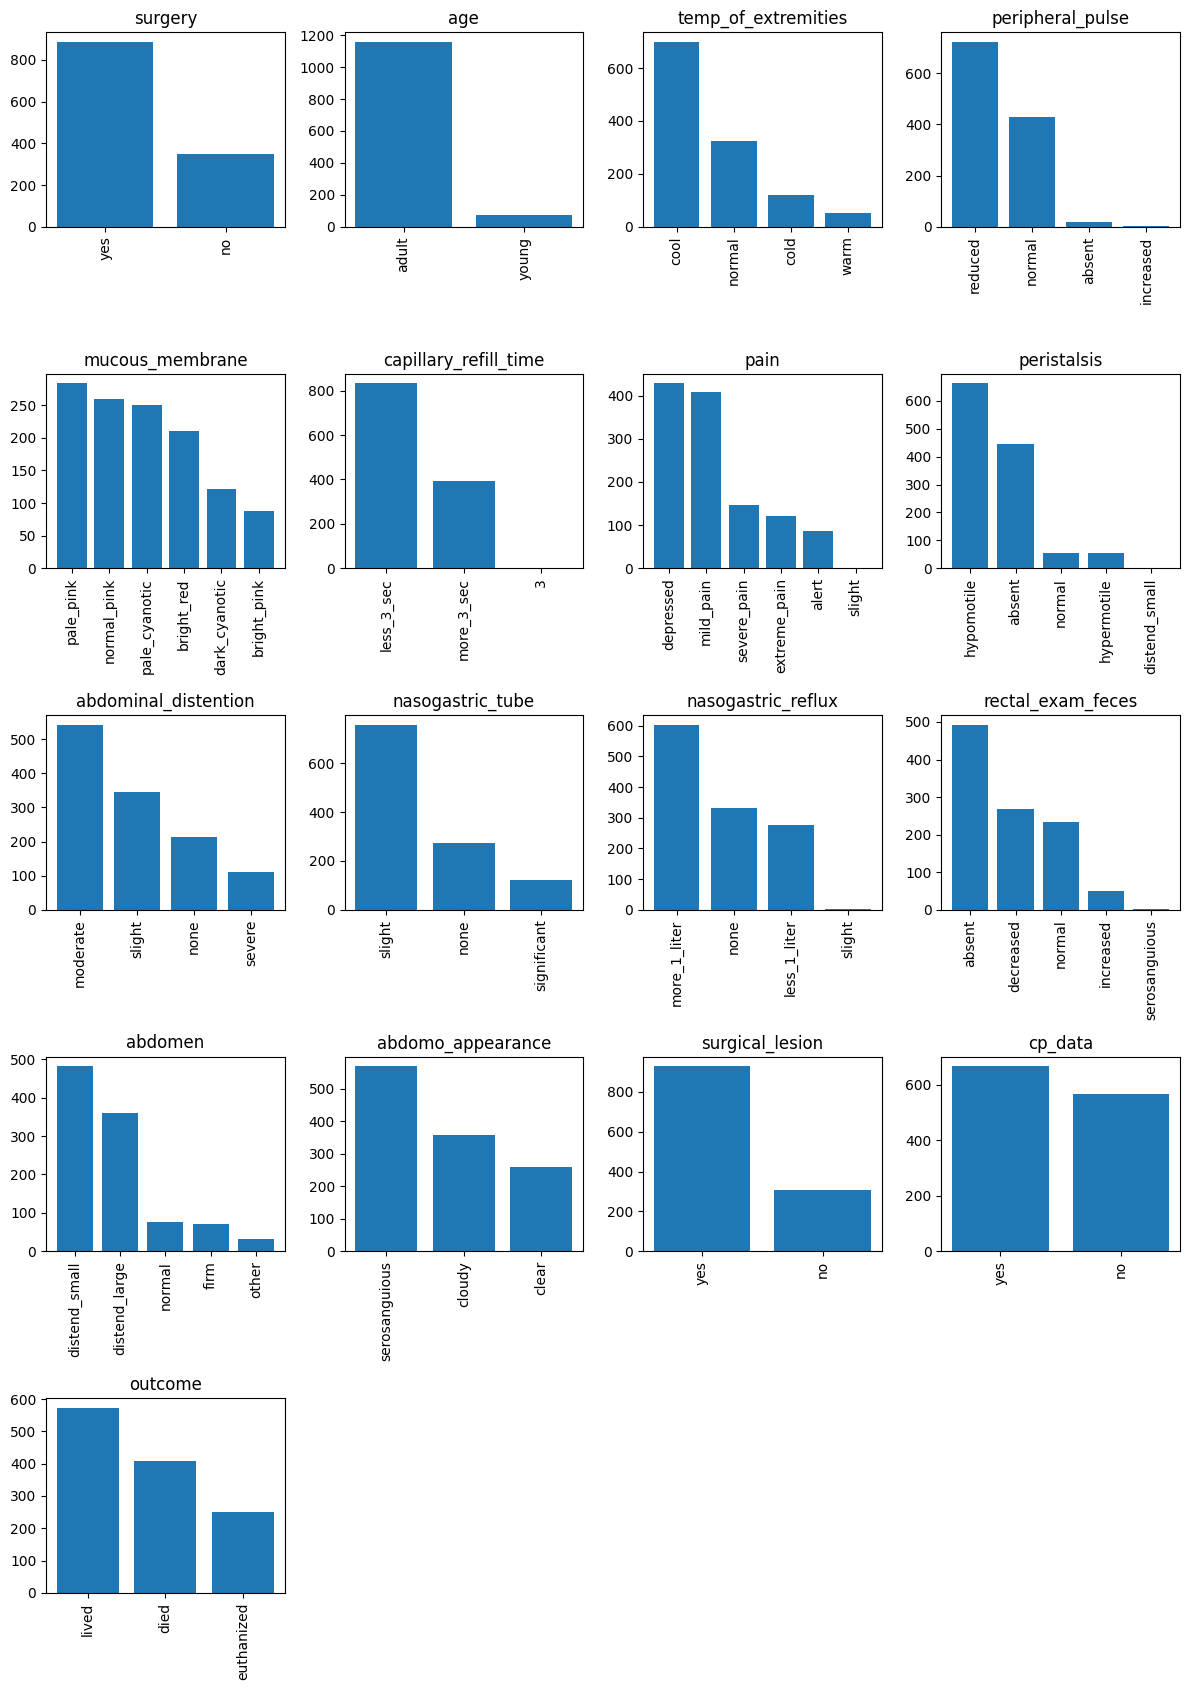

In [58]:
# categorical values --> bar plot
plt.figure(figsize=(12,17))
for i,col in enumerate(object_columns):
    plt.subplot(5,4,i+1)

    category_counts = train[col].value_counts()
    categories = category_counts.index
    counts = category_counts.values

    plt.bar(categories, counts)
    plt.title(col)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

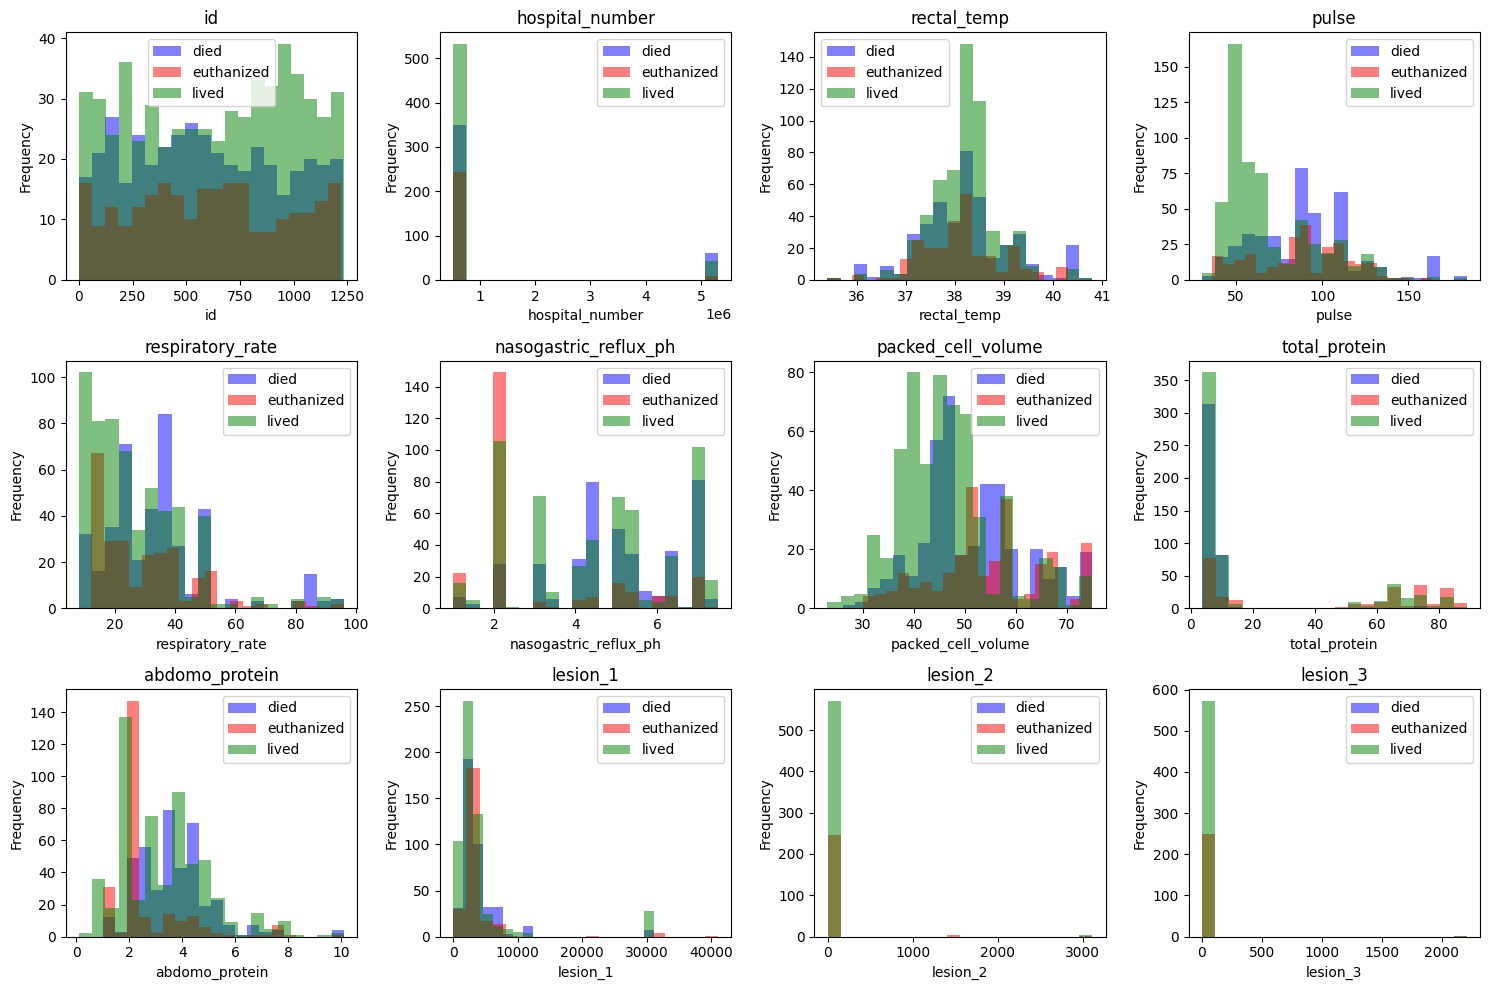

In [88]:
categorical_feature = 'outcome'
categories = train[categorical_feature].unique()
colors = ['blue', 'red', 'green']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, start=1):
    plt.subplot(3, 4, i)
    for j, category in enumerate(categories):
        category_data = train[train[categorical_feature] == category]
        plt.hist(category_data[col], bins=20, color=colors[j], alpha=0.5, label=category)

    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

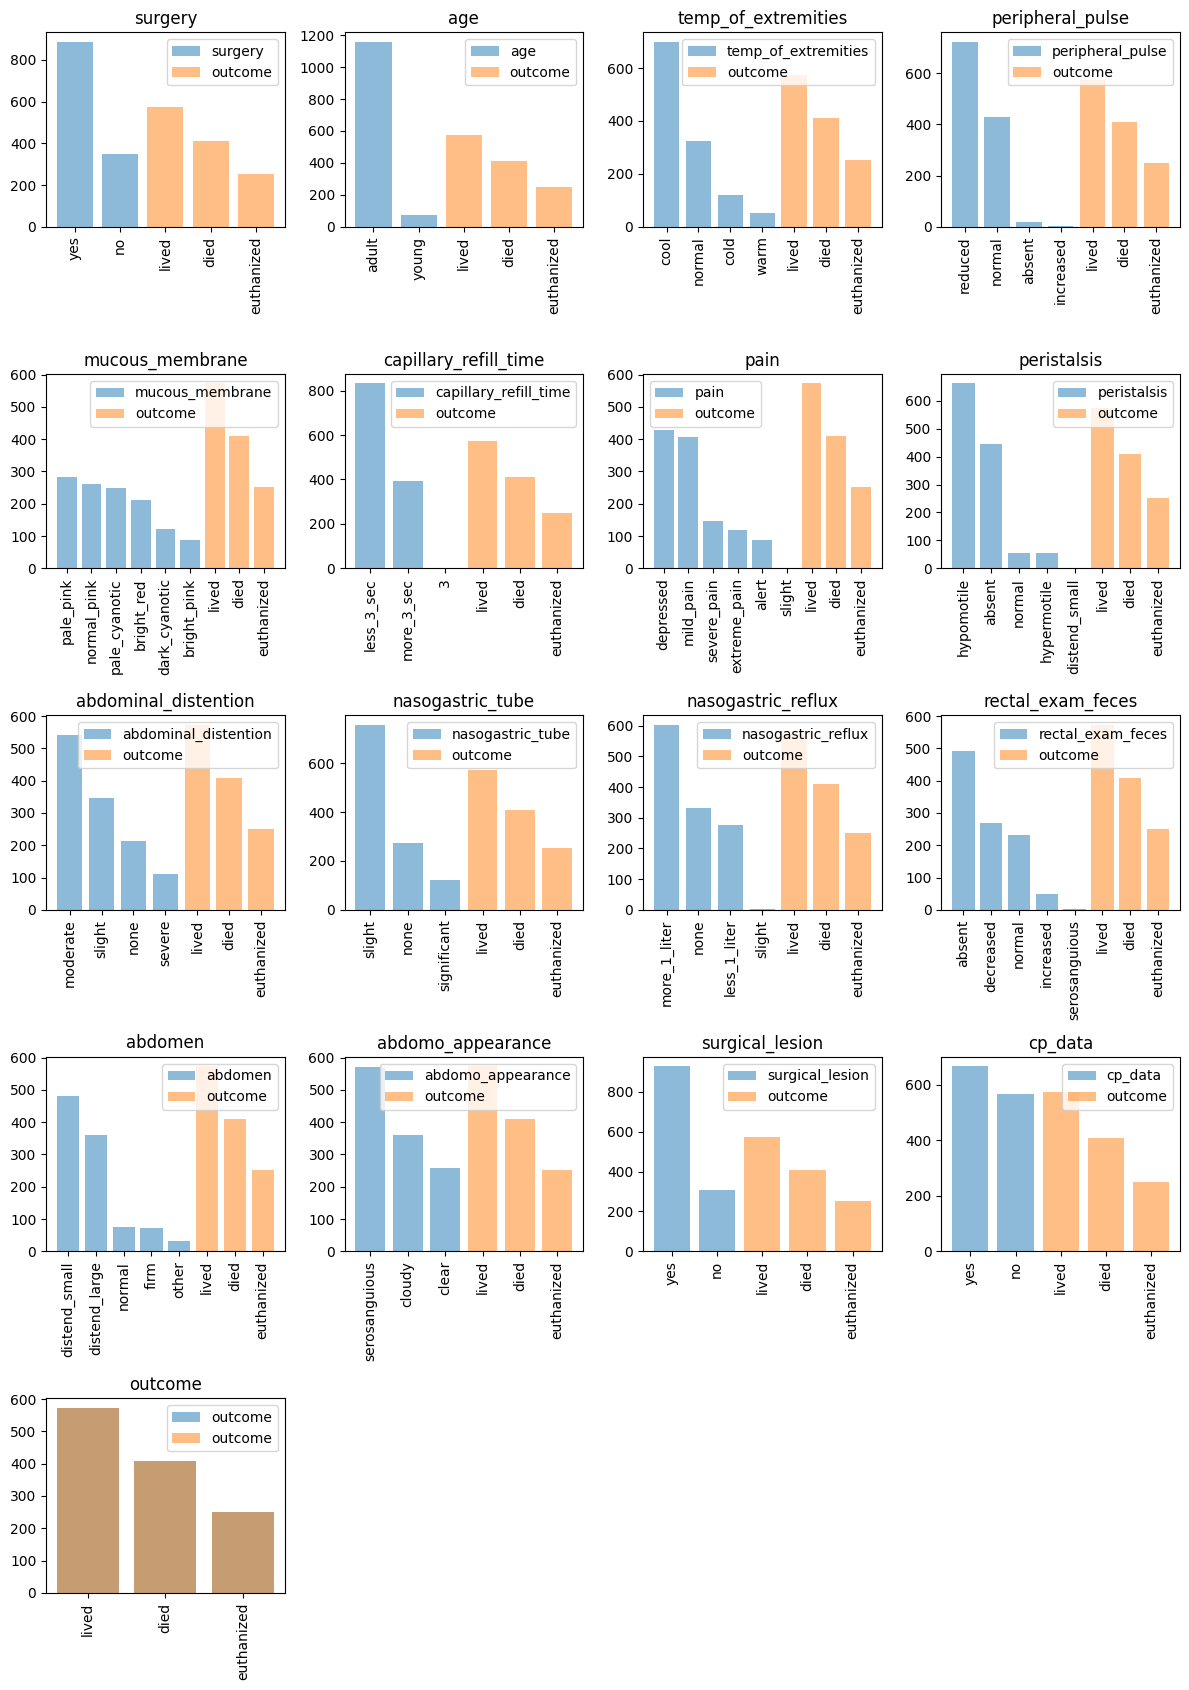

In [89]:
plt.figure(figsize=(12, 17))
reference_column = 'outcome' 

reference_counts = train[reference_column].value_counts()
reference_categories = reference_counts.index
reference_values = reference_counts.values

for i, col in enumerate(object_columns):
    plt.subplot(5, 4, i + 1)

    category_counts = train[col].value_counts()
    categories = category_counts.index
    counts = category_counts.values

    plt.bar(categories, counts, alpha=0.5, label=col)
    plt.bar(reference_categories, reference_values, alpha=0.5, label=reference_column)

    plt.title(col)
    plt.xticks(rotation=90)
    plt.legend()

plt.tight_layout()
plt.show()

In [92]:
# promissing features
### pulse
### packed_cell_volume
### abdominal_distention

## Data Cleaning and Preperation for Machine Learning

* Perform any data cleaning. Be clear what are you doing, for what feature.
* Determinine if rescaling is important for your Machine Learning model.
    * If so select strategy for each feature.
    * Apply rescaling.
* Visualize the features before and after cleaning and rescaling.
* One-hot encode your categorical features.

In [60]:
train_clean=train.copy()

In [61]:
# duplicates
print("number of duplicates: ",train_clean.duplicated().sum())

number of duplicates:  0


In [62]:
# remove columns 
### id
### hospital_number
### cp_data

train_clean=train_clean.drop(["id","hospital_number","cp_data"], axis=1)

In [63]:
# null: all categorical features --> impute mode

impute_col=["temp_of_extremities","peripheral_pulse","mucous_membrane","capillary_refill_time",
            "pain","peristalsis","abdominal_distention","nasogastric_tube","nasogastric_reflux",
            "rectal_exam_feces","abdomen","abdomo_appearance"]

for col in impute_col:
    train_clean[col].fillna(train_clean[col].mode()[0], inplace=True)

/tmp/ipykernel_182561/4085402156.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_clean[col].fillna(train_clean[col].mode()[0], inplace=True)


In [64]:
# no outliers

In [65]:
# nasogastric_reflux has an inconsistant label ('slight')
# rectal_exam_feces has an inconsistant label ('serosanguious')
### replace word with mode

train_clean["nasogastric_reflux"].replace("slight",train_clean["nasogastric_reflux"].mode()[0], inplace=True)
train_clean["rectal_exam_feces"].replace("serosanguious",train_clean["rectal_exam_feces"].mode()[0], inplace=True)

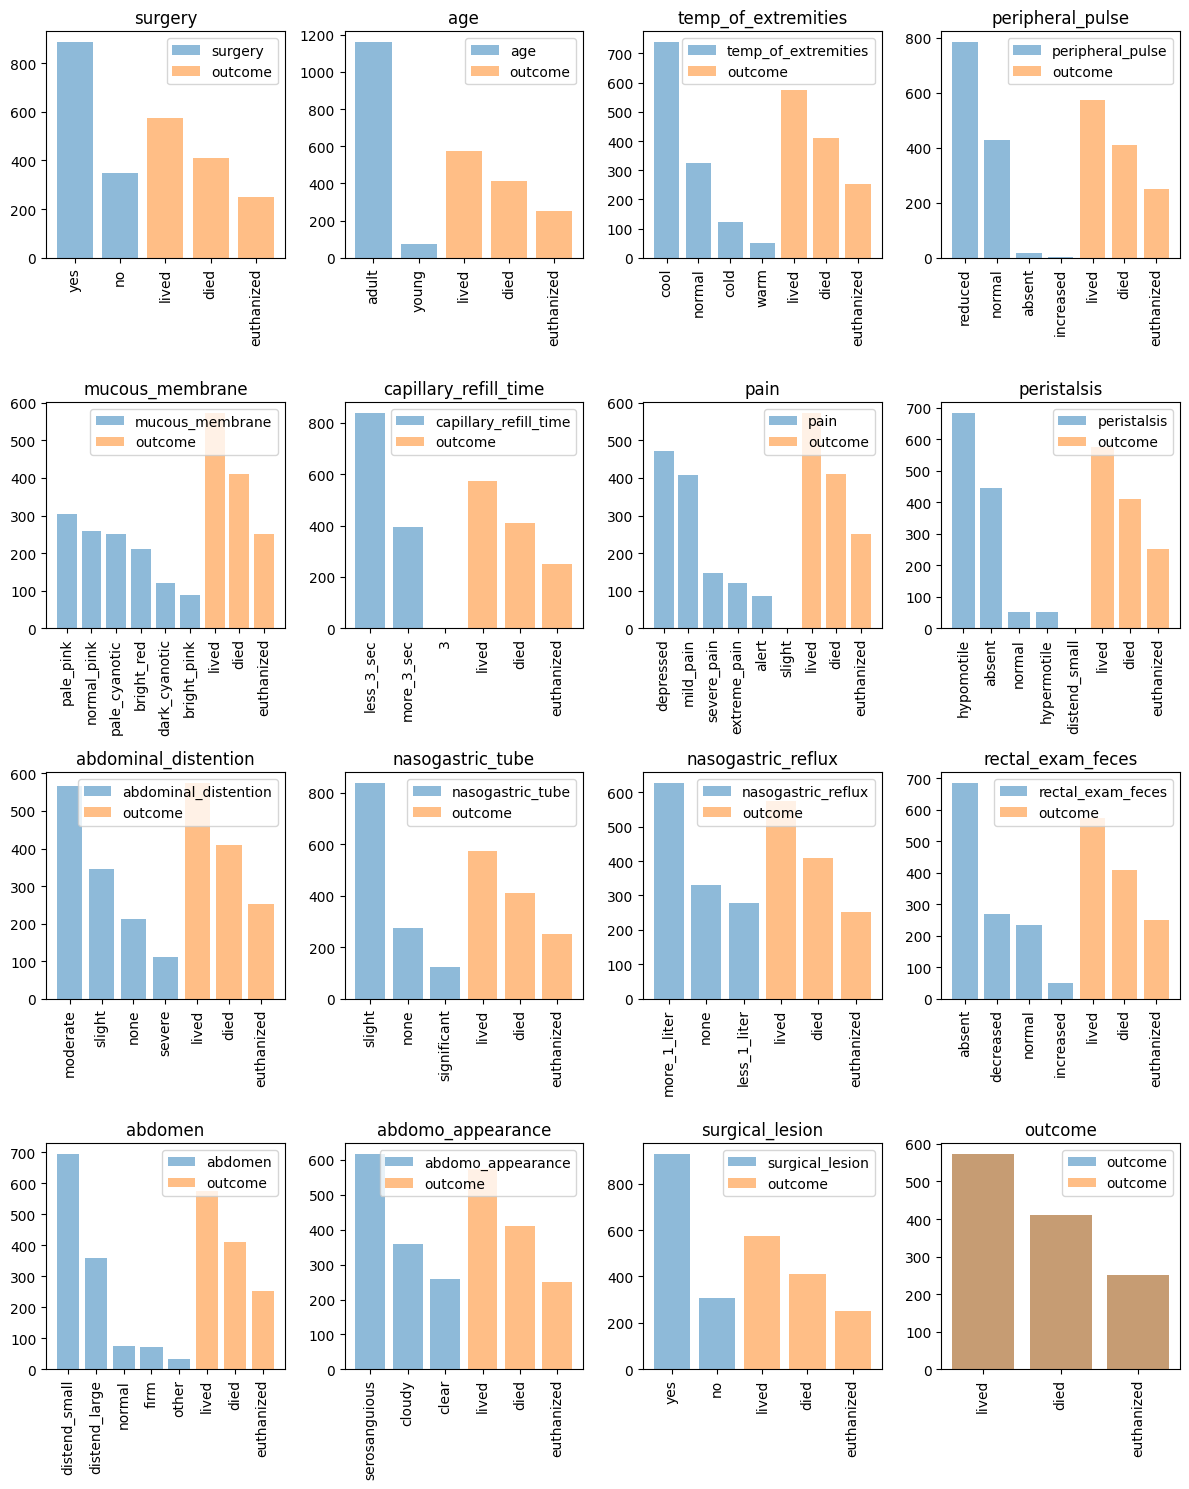

In [100]:
# visualize features
### only categorical values got changed

object_columns_clean = train_clean.select_dtypes(include=['object']).columns

plt.figure(figsize=(12, 15))
reference_column = 'outcome' 

reference_counts = train_clean[reference_column].value_counts()
reference_categories = reference_counts.index
reference_values = reference_counts.values

for i, col in enumerate(object_columns_clean):
    plt.subplot(4, 4, i + 1)

    category_counts = train_clean[col].value_counts()
    categories = category_counts.index
    counts = category_counts.values

    plt.bar(categories, counts, alpha=0.5, label=col)
    plt.bar(reference_categories, reference_values, alpha=0.5, label=reference_column)

    plt.title(col)
    plt.xticks(rotation=90)
    plt.legend()

plt.tight_layout()
plt.show()

In [67]:
# split dependent and independent features

X_train=train_clean.drop("outcome", axis=1)
y_train=train_clean["outcome"] # target feature

### given train and test .csv
### split train.csv into 90% train 10% validation
X_train_90, X_validation_10, y_train_90, y_validation_10 = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [68]:
# encode (onehot) --> X_train_90, X_validation_10
ob_col=["temp_of_extremities","mucous_membrane","peripheral_pulse","capillary_refill_time",
        "pain","peristalsis","abdominal_distention","nasogastric_tube","nasogastric_reflux",
        "rectal_exam_feces","abdomen","abdomo_appearance","surgery","age","surgical_lesion"]

onehot=OneHotEncoder()
column_transformer=ColumnTransformer(transformers=[("one_hot", onehot, ob_col)], remainder="passthrough")
encoded_features=np.array(column_transformer.fit_transform(X_train_90))
encoded_val=column_transformer.transform(X_validation_10)

# encode (label) --> y_train_90
label=LabelEncoder()
encoded_target = label.fit_transform(y_train_90)
encoded_val_t = label.transform(y_validation_10)

## Machine Learning


### Problem Formulation

* Remove unneed columns, for example:
    * duplicated
    * categorical features that were turned into one-hot.
    * features that identify specific rows, like ID number.
    * make sure your target is properly encoded also.
* Split training sample into train, validation, and test sub-samples.

### Train ML Algorithm

* You only need one algorithm to work. You can do more if you like.
* For now, focus on making it work, rather than best result.
* Try to get a non-trivial result.

### Evaluate Performance on Validation Sample

* Compute the usual metric for your ML task.
* Compute the score for the kaggle challenge.

### Apply ML to the challenge test set

* Once trained, apply the ML algorithm the the test dataset and generate the submission file.


In [69]:
# problem formulation

### 0 duplicates (shown previously)
### one hot (shown previously)
### removed id columns (shown previously)
### target encoded (shown previously)

### split into train, validation, test (shown previously)

In [70]:
# train ML algorithm - decision tree

dt_pipeline = Pipeline(steps=[('onehot', column_transformer),
                                      ('regressor', DecisionTreeRegressor())])

dt_pipeline.fit(X_train_90, encoded_target)

Pipeline(steps=[('onehot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  ['temp_of_extremities',
                                                   'mucous_membrane',
                                                   'peripheral_pulse',
                                                   'capillary_refill_time',
                                                   'pain', 'peristalsis',
                                                   'abdominal_distention',
                                                   'nasogastric_tube',
                                                   'nasogastric_reflux',
                                                   'rectal_exam_feces',
                                                   'abdomen',
                                                   'abdomo_appearance',
                                                   'surgery', 'age',
                                                   'surgical_lesion'])])),
                ('regressor', DecisionTreeRegressor())])

In [71]:
# evaluate performance on validation sample

y_val_dt=dt_pipeline.predict(X_validation_10)

dt_val_df=pd.DataFrame([y_val_dt], index=["predicted"]).T
dt_val_df["actual"]=encoded_val_t


dt_val_df["accuracy"] = (dt_val_df["predicted"] == dt_val_df["actual"]).astype(int)

print("correct predictions: ",(dt_val_df["accuracy"].sum()/len(dt_val_df["accuracy"]))*100,"%")


correct predictions:  50.0 %


In [72]:
# test set
test_clean=test.copy()

### preprocessing similar to train dataset
ob_col=["temp_of_extremities","mucous_membrane","peripheral_pulse","capillary_refill_time",
        "pain","peristalsis","abdominal_distention","nasogastric_tube","nasogastric_reflux",
        "rectal_exam_feces","abdomen","abdomo_appearance","surgery","age","surgical_lesion"]
for col in ob_col:
    mode_value = train_clean[col].mode()[0]
    test_clean[col] = test_clean[col].apply(lambda x: mode_value if x not in train_clean[col].unique() else x)
column_transformer.fit(X_train_90)
encoded_features = column_transformer.transform(test_clean)

# predictions
y_pred = dt_pipeline.predict(test_clean)


y_test=encoded_target[:824] # make list same length
rmse_dt_numerical = np.sqrt(mean_squared_error(y_test, y_pred))
r2_dt_numerical = r2_score(y_test, y_pred)

print("RMSE: ", rmse_dt_numerical)
print("r^2: ", r2_dt_numerical)

RMSE:  1.2497572579839236
r^2:  -0.9408673881174745


In [73]:
# Calculate micro-averaged precision, recall, and F1-score
micro_precision = precision_score(y_test, y_pred, average='micro')
micro_recall = recall_score(y_test, y_pred, average='micro')
micro_f1 = f1_score(y_test, y_pred, average='micro')

# Calculate macro-averaged precision, recall, and F1-score
macro_precision = precision_score(y_test, y_pred, average='macro')
macro_recall = recall_score(y_test, y_pred, average='macro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)
print("Micro F1-score:", micro_f1)
print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1-score:", macro_f1)


Micro Precision: 0.3883495145631068
Micro Recall: 0.3883495145631068
Micro F1-score: 0.3883495145631068
Macro Precision: 0.3349556038631669
Macro Recall: 0.33590105440230306
Macro F1-score: 0.3352963933388433


In [80]:
result_df=test_clean.copy()
result_df["outcome"]=y_pred
dropping=['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2', 'lesion_3',
       'cp_data']
result_df=result_df.drop(dropping, axis=1)

In [81]:
result_df

,id,outcome
0,1235,2.0
1,1236,0.0
2,1237,2.0
3,1238,1.0
4,1239,2.0
...,...,...
819,2054,0.0
820,2055,1.0
821,2056,2.0
822,2057,2.0


In [90]:
result_df['outcome'] = result_df['outcome'].map({0:'died', 1: 'euthanized', 2: 'lived'})

In [91]:
result_df

,id,outcome
0,1235,lived
1,1236,died
2,1237,lived
3,1238,euthanized
4,1239,lived
...,...,...
819,2054,died
820,2055,euthanized
821,2056,lived
822,2057,lived
